In [1]:
from plots import plot_clusters
import pandas as pd
import os
import matplotlib.pyplot as plt

C:\Users\Impasse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
os.path.exists("../data/clusters_avg.csv")

False

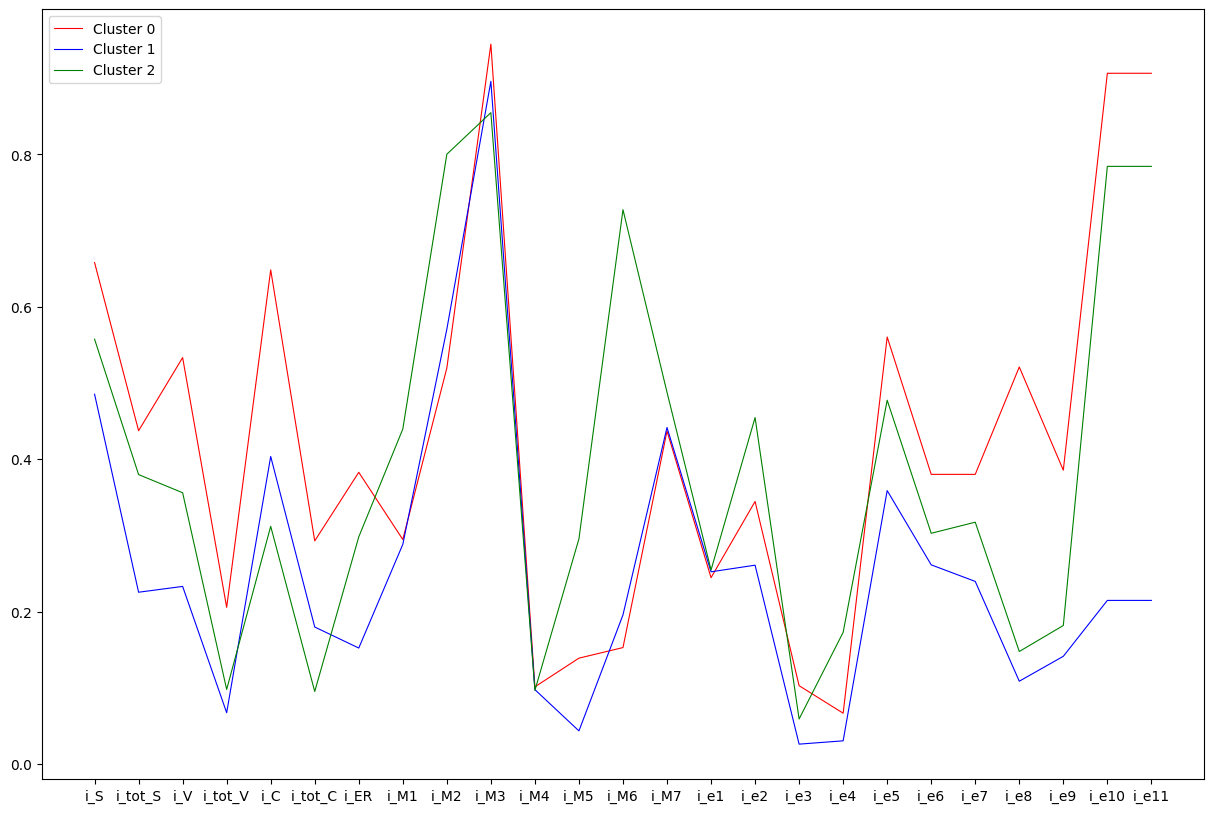

In [3]:
avg = pd.read_csv("../data/clusters_means.csv")

# avg = plot_clusters(df)

zero, ones, twos = avg.loc[0], avg.loc[1], avg.loc[2]

plt.figure(figsize=(15, 10))

# y = [487, 525, 835, 1142, 1228]
colors = ["red", "blue", "green"]
avgs = [zero[1:], ones[1:], twos[1:]]
for i in range(len(avgs)):
    plt.plot(avgs[i], color=colors[i], label=f"Cluster {i}", linewidth=0.8)


plt.legend()
plt.show()

In [6]:
import pandas as pd
from poll_processing import execute_pipeline, init_spark
from run_algorithms import run_kmeans, directories

spark = init_spark()
df = pd.read_csv('../data/df_indexes.csv')

centroids = run_kmeans(spark, df)
centroids

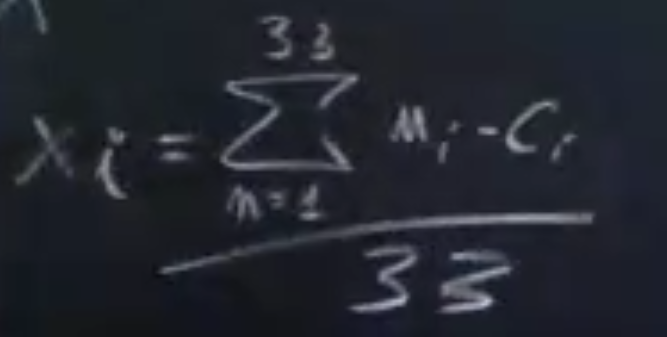

In [15]:
centroids = [[c[1:]] for c in centroids]

clusters_df = pd.read_csv("../data/clusters.csv")

c_0 = clusters_df[clusters_df["cluster_idx"] == 0]
c_1 = clusters_df[clusters_df["cluster_idx"] == 1]
c_2 = clusters_df[clusters_df["cluster_idx"] == 2]

clusters_df = [c_0, c_1, c_2]
x_i = []
for c in clusters_df:
    sum([m for m in c_0.iterrows()])

,Unnamed: 0,i_S,i_tot_S,i_V,i_tot_V,i_C,i_tot_C,i_ER,i_M1,i_M2,...,i_e3,i_e4,i_e5,i_e6,i_e7,i_e8,i_e9,i_e10,i_e11,cluster_idx
41,26,0.826,0.456,0.524,0.200,0.71,0.440,0.556,0.599,0.4,...,0.10,0.10,0.500,0.50,0.50,0.688,0.500,0.875,0.875,2
42,48,0.638,0.729,0.744,0.300,0.85,0.327,0.667,0.299,0.5,...,0.15,0.00,0.250,0.33,0.17,0.938,0.875,0.875,0.875,2
43,47,0.536,0.606,1.000,0.750,1.00,0.500,0.000,0.479,0.4,...,0.15,0.05,0.250,0.17,0.33,0.562,0.188,0.875,0.875,2
44,12,0.754,0.263,0.220,0.050,0.57,0.660,0.222,0.120,0.5,...,0.15,0.15,0.500,0.50,0.67,0.500,0.250,1.000,1.000,2
45,13,0.667,0.223,0.329,0.076,0.85,0.327,0.611,0.240,0.5,...,0.00,0.05,0.250,0.33,0.50,0.312,0.438,1.000,1.000,2
46,17,0.710,0.545,0.610,0.300,0.85,0.327,1.000,0.749,0.4,...,0.00,0.00,0.667,0.33,0.33,0.188,0.188,1.000,1.000,2
47,37,0.783,0.485,0.329,0.076,0.71,0.440,0.111,0.120,0.6,...,0.10,0.00,0.750,0.33,0.17,0.562,0.375,0.750,0.750,2
48,22,1.000,0.517,0.500,0.224,0.57,0.220,0.667,0.599,1.0,...,0.40,0.40,0.500,0.67,0.83,1.000,1.000,1.000,1.000,2
49,33,0.638,0.183,0.744,0.300,0.85,0.327,0.889,0.120,0.6,...,0.00,0.15,0.500,0.50,0.33,0.750,0.750,1.000,1.000,2
50,42,0.232,0.060,0.549,0.124,0.43,0.327,0.500,0.120,0.5,...,0.15,0.00,1.000,0.17,0.17,1.000,0.688,0.750,0.750,2
